In [1]:
import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [2]:
# Load wrat

idWratDict = {}

with open('../../wrat.csv') as f:
    for line in f.readlines()[1:]:
        parts = line.split(',')
        try:
            idWratDict[int(parts[0])] = int(parts[3])
        except Exception as e:
            print(parts[0])
            print(e)

603056110671
invalid literal for int() with base 10: 'NaN\n'
603317055381
invalid literal for int() with base 10: 'NaN\n'
604847970437
invalid literal for int() with base 10: 'NaN\n'


In [3]:
import numpy as np

train_wrat = []
test_wrat = []
wrat_ids = idWratDict.keys()
y_train = []
y_test = []

for subj in train:
    if subj['ID'] in wrat_ids:
        train_wrat.append(subj)
        y_train.append(idWratDict[subj['ID']])
        
for subj in test:
    if subj['ID'] in wrat_ids:
        test_wrat.append(subj)
        y_test.append(idWratDict[subj['ID']])

y_train = np.array(y_train)
y_test = np.array(y_test)
print(y_train.shape)
print(y_test.shape)
print(len(train_wrat))
print(len(test_wrat))

(446,)
(148,)
446
148


In [4]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train_wrat]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test_wrat]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [5]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_rest_ts_torch = [torch.from_numpy(ts).float().cuda() for ts in train_rest_ts]
test_rest_ts_torch = [torch.from_numpy(ts).float().cuda() for ts in test_rest_ts]

print('Complete')

Complete


In [47]:
import math

nroi = train_rest_ts_torch[0].shape[0]
nt = train_rest_ts_torch[0].shape[1]
nc = 10

sz1 = math.floor((nt-8)/2+1)
sz2 = math.floor((sz1-8)/2+1)
sz3 = math.floor((sz2-8)/2+1)
sz4 = math.floor((sz3-8)/2+1)

class WratCNN(nn.Module):
    def __init__(self):
        super(WratCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,nc,(nroi,8),(1,2)).cuda()
        self.mp1 = nn.MaxPool2d((1,8),(1,2))
        self.conv2 = nn.Conv2d(nc,nc,(1,8),(1,2)).cuda()
        self.mp2 = nn.MaxPool2d((1,8),(1,2))
        self.fc1 = nn.Linear(nc*sz4,100).cuda()
        self.fc2 = nn.Linear(100,1).cuda()
        
    def forward(self, x):
        nb = x.shape[0]
        noise = torch.randn(nb,nroi,nt).cuda()/1000
        x = x + noise
        x = F.relu(self.conv1(x.unsqueeze(1)))
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = x.reshape([nb,-1])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
wratcnn = WratCNN()
optim = torch.optim.Adam(wratcnn.parameters(), lr=1e-3)

print('Complete')

Complete


In [48]:
# Train CNN

import random

N = len(train_rest_ts_torch)
running = 0
nEpoch = 1500
pPeriod = 100
nBatch = 10

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch).cuda()
    for i in range(nBatch):
        idx = random.randint(0,N-1)
        subj = train_rest_ts_torch[idx]
        batch.append(subj)
        truth[i] = y_train[idx]
    batch = torch.stack(batch,dim=0)
    optim.zero_grad()
    pred = wratcnn(batch).flatten()
    loss = torch.sum((truth-pred)**2)
    loss.backward()
    running += loss.cpu()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
            else:
                running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=112348.187500
epoch 100 loss=22015.187500
epoch 200 loss=3415.021973
epoch 300 loss=2404.052490
epoch 400 loss=1482.396606
epoch 500 loss=970.273499
epoch 600 loss=652.530518
epoch 700 loss=282.730347
epoch 800 loss=186.567444
epoch 900 loss=136.011276
epoch 1000 loss=62.381607
epoch 1100 loss=41.899887
epoch 1200 loss=26.931114
epoch 1300 loss=10.155415
epoch 1400 loss=4.815742
epoch 1499 loss=2.123032
Finished training


[[1.         0.24274416]
 [0.24274416 1.        ]]
17.582050966128953
13.932017249030036


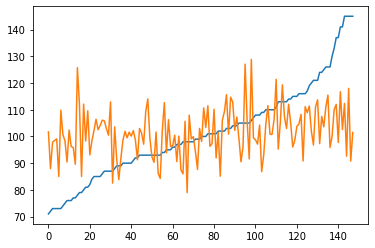

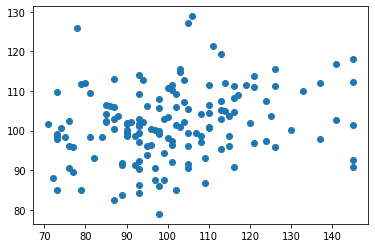

In [49]:
import matplotlib.pyplot as plt

y = y_test
X = []

for subj in test_rest_ts_torch:
    X.append(subj)
    
X = torch.stack(X, dim=0)
yPred = wratcnn(X).flatten().cpu().detach().numpy()

# yPred = Xtest@w

idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5
mae = np.sum(np.abs(y-yPred))/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()